<a href="https://colab.research.google.com/github/Bullet1403/Yelp_dataset/blob/main/IIT_Patna_(yelp).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import json
import seaborn as sns

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.probability import FreqDist
import string

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import  TfidfTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from wordcloud import WordCloud, STOPWORDS

In [ ]:
users = []
with open('/gdrive/MyDrive/archive/yelp_academic_dataset_review.json') as fl:
    for i, line in enumerate(fl):
        users.append(json.loads(line))
        if i == 99999:
            break
rev = pd.DataFrame(users)
rev.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,lWC-xP3rd6obsecCYsGZRg,ak0TdVmGKo4pwqdJSTLwWw,buF9druCkbuXLX526sGELQ,4.0,3,1,1,Apparently Prides Osteria had a rough summer a...,2014-10-11 03:34:02
1,8bFej1QE5LXp4O05qjGqXA,YoVfDbnISlW0f7abNQACIg,RA4V8pr014UyUbDvI-LW2A,4.0,1,0,0,This store is pretty good. Not as great as Wal...,2015-07-03 20:38:25
2,NDhkzczKjLshODbqDoNLSg,eC5evKn1TWDyHCyQAwguUw,_sS2LBIGNT5NQb6PD1Vtjw,5.0,0,0,0,I called WVM on the recommendation of a couple...,2013-05-28 20:38:06
3,T5fAqjjFooT4V0OeZyuk1w,SFQ1jcnGguO0LYWnbbftAA,0AzLzHfOJgL7ROwhdww2ew,2.0,1,1,1,I've stayed at many Marriott and Renaissance M...,2010-01-08 02:29:15
4,sjm_uUcQVxab_EeLCqsYLg,0kA0PAJ8QFMeveQWHFqz2A,8zehGz9jnxPqXtOc7KaJxA,4.0,0,0,0,The food is always great here. The service fro...,2011-07-28 18:05:01


In [ ]:
print(rev.shape)
print(rev.info())

(100000, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   review_id    100000 non-null  object 
 1   user_id      100000 non-null  object 
 2   business_id  100000 non-null  object 
 3   stars        100000 non-null  float64
 4   useful       100000 non-null  int64  
 5   funny        100000 non-null  int64  
 6   cool         100000 non-null  int64  
 7   text         100000 non-null  object 
 8   date         100000 non-null  object 
dtypes: float64(1), int64(3), object(5)
memory usage: 6.9+ MB
None


In [ ]:
reviews = rev.drop(['date','business_id','review_id','user_id'], axis =1)

In [ ]:
reviews['text length'] = rev['text'].apply(len)
reviews.head()

,stars,useful,funny,cool,text,text length
0,4.0,3,1,1,Apparently Prides Osteria had a rough summer a...,1856
1,4.0,1,0,0,This store is pretty good. Not as great as Wal...,701
2,5.0,0,0,0,I called WVM on the recommendation of a couple...,578
3,2.0,1,1,1,I've stayed at many Marriott and Renaissance M...,390
4,4.0,0,0,0,The food is always great here. The service fro...,181


In [ ]:
reviews.isnull().any().any()

False

Text(0, 0.5, 'count')

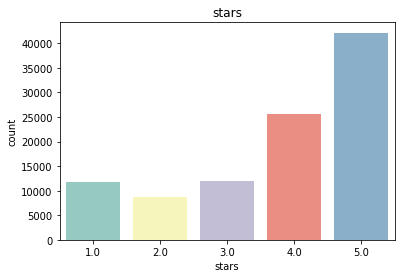

In [ ]:
# The data is skewed to the left
cplot = sns.countplot(x='stars', data=reviews, palette="Set3")
cplot.set_title('stars')
cplot.set_ylabel('count')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Text Length Distribution')

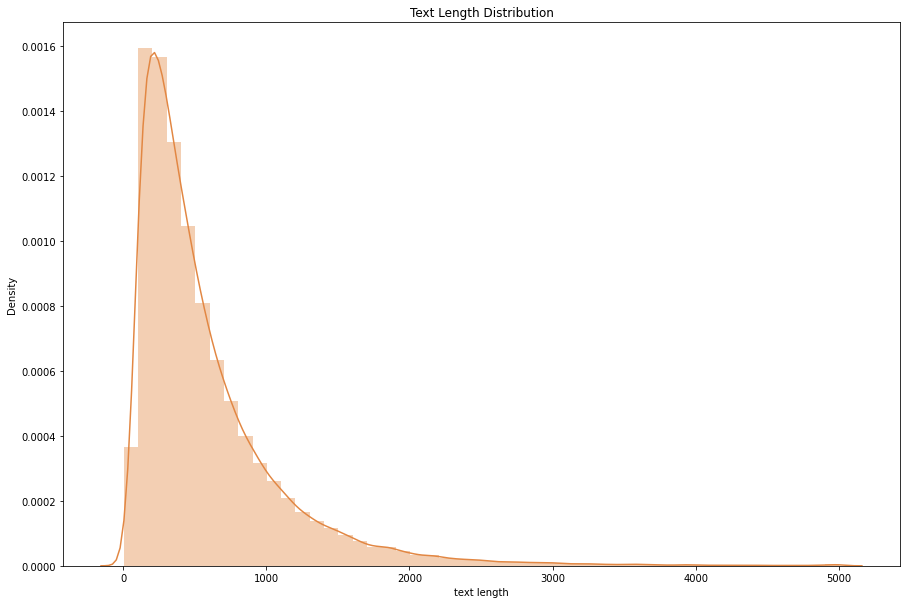

In [ ]:
fig = plt.figure(figsize=(15,10))
sns.distplot(reviews['text length'], kde=True, bins=50, color='#e28743')
plt.title('Text Length Distribution')

In [ ]:
text = reviews[['stars','text']]
text.head()

,stars,text
0,4.0,Apparently Prides Osteria had a rough summer a...
1,4.0,This store is pretty good. Not as great as Wal...
2,5.0,I called WVM on the recommendation of a couple...
3,2.0,I've stayed at many Marriott and Renaissance M...
4,4.0,The food is always great here. The service fro...


In [ ]:
cachedStopWords = stopwords.words("english")

def remove_punc_stopword(text):

    remove_punc = [word for word in text.lower() if word not in string.punctuation]
    remove_punc = ''.join(remove_punc)
    return [word for word in remove_punc.split() if word not in cachedStopWords]

In [ ]:
cleaned_text = text.copy()
cleaned_text['text'] = text['text'].apply(remove_punc_stopword)
cleaned_text.head()

,stars,text
0,4.0,"[apparently, prides, osteria, rough, summer, e..."
1,4.0,"[store, pretty, good, great, walmart, preferre..."
2,5.0,"[called, wvm, recommendation, couple, friends,..."
3,2.0,"[ive, stayed, many, marriott, renaissance, mar..."
4,4.0,"[food, always, great, service, manager, well, ..."


In [ ]:
def plot_Freq(data):
    FreqDist(np.concatenate(data.text.reset_index(drop=True))).plot(20, cumulative=False)

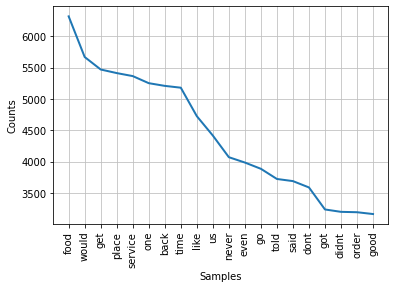

In [ ]:
plot_Freq(cleaned_text[cleaned_text['stars']==1])

In [ ]:
# Wordcloud of words which occur most frequently in negative reviews (1 star)
def reviewCloud(star):
    startext = ' '.join(text[text['stars']==star]['text'])
    wordcloud = WordCloud(
        width = 3000,
        height = 2000,
        background_color = 'black',
        stopwords = STOPWORDS).generate(str(startext))

    fig = plt.figure(
        figsize = (10, 7),
        facecolor = 'k',
        edgecolor = 'c')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)

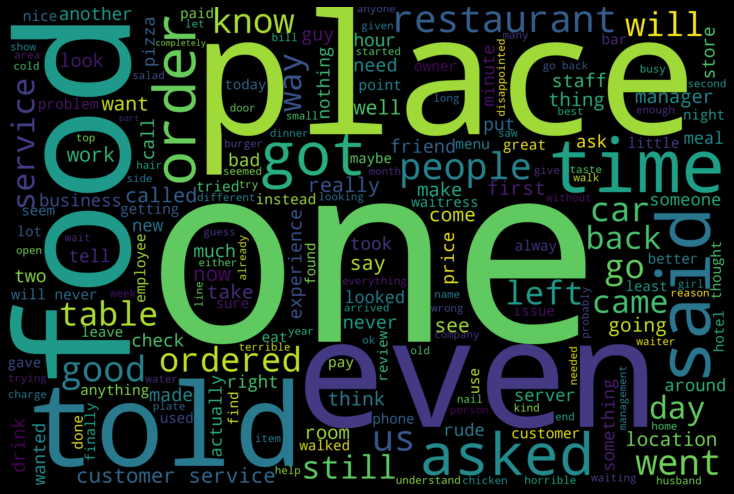

In [ ]:
reviewCloud(1)

In [ ]:
rev.loc[86353,:]

review_id                                 5ebBdavfoV-ErZEuf_62RQ
user_id                                   Lghn5Pk9JVXfDetoYzod4A
business_id                               iDcT8noFyv1sEVzzEWq1ow
stars                                                        5.0
useful                                                         1
funny                                                          1
cool                                                           1
text           This is one of your standard Chinese buffets. ...
date                                         2018-08-05 23:33:48
Name: 86353, dtype: object

In [ ]:
restaurant = rev[rev.business_id==rev.loc[14544,:].business_id]
restaurant.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
5472,lsRsege54gdazajXOnbuug,DDnaZjXiCMtDG_SBbeMewQ,k-ou6U8a_jTcN3aq9HvuRA,3.0,0,0,0,So my husband and I go here all the time and b...,2018-01-21 05:37:15
6486,OJbLlYGKZA15qvqOAAvVIw,NQn4xfxJ_-G5uPr15jQmXA,k-ou6U8a_jTcN3aq9HvuRA,5.0,1,0,0,This is in a strip mall next to Mongolian BBQ ...,2010-08-22 00:27:57
8622,jCqs3jcJ106fXjPLVhx1Jg,I8J5tiheti6meBlqJFiHWQ,k-ou6U8a_jTcN3aq9HvuRA,4.0,0,0,0,Love the steamed chicken dumplings and the sin...,2016-03-31 00:13:51
9387,v8aTTZYOtsF7-GDEy3lGjg,ku58KfuRXbaSgAZrmmFbNg,k-ou6U8a_jTcN3aq9HvuRA,3.0,1,0,0,"I had sushi here, and it was alright. I got th...",2014-11-12 17:53:57
14544,aqcv6MNigMPGUdQYgq51iw,BmE_IKPT54fw3qeraYKt5g,k-ou6U8a_jTcN3aq9HvuRA,4.0,1,0,0,A friend and I checked out Blue Ginger this Sa...,2013-06-24 15:22:23


In [ ]:
selected_words = ['chinese', 'japanese', 'asian' , 'fastfood', 'seafood', 'steakhouse', 'mexican', 'thai', 
                  'turkish', 'diet','healthy']

In [ ]:
vectorizer = CountVectorizer(vocabulary=selected_words, lowercase=False)

selected_word_count = vectorizer.fit_transform(restaurant['text'].values.astype('U'))
vectorizer.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['chinese',
 'japanese',
 'asian',
 'fastfood',
 'seafood',
 'steakhouse',
 'mexican',
 'thai',
 'turkish',
 'diet',
 'healthy']

In [ ]:
word_count_array = selected_word_count.toarray()
word_count_array.shape

(27, 11)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


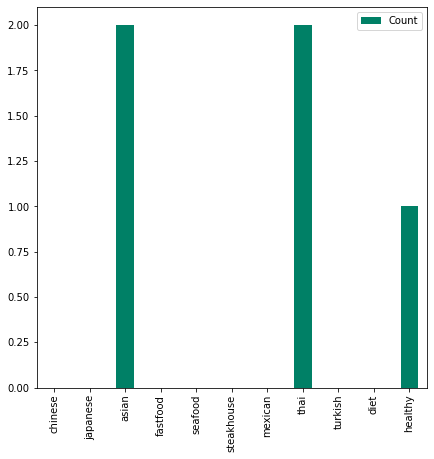

In [ ]:
rest = pd.DataFrame(index=vectorizer.get_feature_names(), \
                    data=word_count_array.sum(axis=0)).rename(columns={0: 'Count'})

rest.plot(kind='bar', stacked=False, figsize=[7,7], colormap='summer')

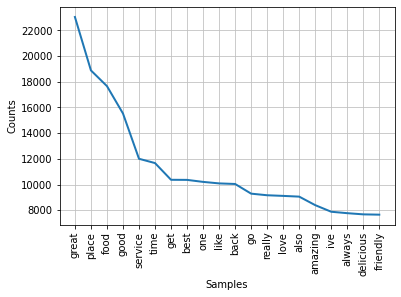

In [ ]:
def plot_Freq(data):
    FreqDist(np.concatenate(data.text.reset_index(drop=True))).plot(20, cumulative=False)
    
plot_Freq(cleaned_text[cleaned_text['stars']==5])

In [ ]:
select_stars = text[(text['stars']==1) | (text['stars']==5)]

In [ ]:
x = select_stars['text']
y = select_stars['stars']

In [ ]:
count_vec = CountVectorizer().fit(x)
x = count_vec.transform(x)

In [ ]:
x.shape

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)

In [ ]:
dectree  = DecisionTreeClassifier(criterion = "entropy")
dectree.fit(x_train,y_train)
dectree_pred = dectree.predict(x_test)

print("Confusion Matrix for Decision Tree:")
print(confusion_matrix(y_test,dectree_pred))
print("Score:",round(accuracy_score(y_test,dectree_pred)*100,2))
print("Classification Report:",classification_report(y_test,dectree_pred))

Confusion Matrix for Decision Tree:
[[1753  632]
 [ 616 7784]]
Score: 88.43
Classification Report:               precision    recall  f1-score   support

         1.0       0.74      0.74      0.74      2385
         5.0       0.92      0.93      0.93      8400

    accuracy                           0.88     10785
   macro avg       0.83      0.83      0.83     10785
weighted avg       0.88      0.88      0.88     10785

